In [20]:
import pandas as pd
import Levenshtein as lev
from scipy.spatial.distance import pdist, squareform
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import networkx as nx
import gravis as gv

# Note you will need to download muscle into the usr/bin and rename it simply as muscle
import biotite.sequence as seq
import biotite.application.muscle as muscle
import biotite.sequence.graphics as graphics

from scipy.stats import mode

import itertools

# Set 1

In [2]:
os.chdir('/home/jupyter') #/data')

In [3]:
pool1 = pd.read_csv("data/ILT4-pool1-10062022/filtered_contig_annotations.csv")
#pool1 = pd.read_csv("ILT4-pool1-10062022/airr_rearrangement.tsv", sep="\t")
#pool1_filtered_barcodes = pd.read_csv("ILT4-pool1-10062022/filtered_contig_annotations.csv", usecols=['barcode'])['barcode'].to_list()
#pool1 = pool1[pool1.cell_id.isin(pool1_filtered_barcodes)]
pool1['sample_num'] = "pool_1"

pool2 = pd.read_csv("data/ILT4-pool2-10062022/filtered_contig_annotations.csv")
#pool2 = pd.read_csv("ILT4-pool2-10062022/airr_rearrangement.tsv", sep="\t")
#pool2_filtered_barcodes = pd.read_csv("ILT4-pool2-10062022/filtered_contig_annotations.csv", usecols=['barcode'])['barcode'].to_list()
#pool2 = pool2[pool2.cell_id.isin(pool2_filtered_barcodes)]
pool2['sample_num'] = "pool_2"

config = pd.concat([pool1, pool2], axis=0).reset_index(drop=True)
config

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id,sample_num
0,AAACCTGAGCTCTCGG-1,True,AAACCTGAGCTCTCGG-1_contig_1,True,516,IGK,IGKV8-24,NaN,IGKJ2,IGKC,...,CQQHYSTPYTF,TGTCAGCAACATTATAGCACTCCGTACACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,2552,11,clonotype1,clonotype1_consensus_2,1,pool_1
1,AAACCTGAGCTCTCGG-1,True,AAACCTGAGCTCTCGG-1_contig_2,True,568,IGH,IGHV1-53,NaN,IGHJ4,IGHG1,...,CARYYKYDYYAMDFW,TGTGCAAGATACTATAAATACGACTACTATGCTATGGACTTCTGG,GQGTSVTVSS,GGTCAAGGAACCTCAGTCACCGTCTCCTCAG,718,1,clonotype1,clonotype1_consensus_1,1,pool_1
2,AAACCTGAGTGCCATT-1,True,AAACCTGAGTGCCATT-1_contig_1,True,481,IGK,IGKV6-32,NaN,IGKJ2,IGKC,...,CQQDYSSLTF,TGTCAGCAGGATTATAGCTCTCTCACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,154,14,clonotype321,clonotype321_consensus_1,1,pool_1
3,AAACCTGCAAGCTGAG-1,True,AAACCTGCAAGCTGAG-1_contig_1,True,514,IGK,IGKV8-24,NaN,IGKJ2,IGKC,...,CQQHYSTPYTF,TGTCAGCAACATTATAGCACTCCGTACACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,508,5,clonotype9,clonotype9_consensus_1,1,pool_1
4,AAACCTGCACATTCGA-1,True,AAACCTGCACATTCGA-1_contig_1,True,522,IGK,IGKV1-117,NaN,IGKJ2,IGKC,...,CFQGSHVPYTF,TGCTTTCAAGGTTCACATGTTCCGTACACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,234,15,clonotype5,clonotype5_consensus_1,1,pool_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16779,TTTGTCATCACCCGAG-1,True,TTTGTCATCACCCGAG-1_contig_2,True,651,IGH,IGHV2-9,NaN,IGHJ2,IGHM,...,CARDLYDYYFDYW,TGTGCCAGAGATCTCTATGATTACTACTTTGACTACTGG,GQGTTLTVSS,GGCCAAGGCACCACTCTCACAGTCTCCTCAG,2758,15,clonotype1362,clonotype1362_consensus_1,1,pool_2
16780,TTTGTCATCACGATGT-1,True,TTTGTCATCACGATGT-1_contig_1,True,523,IGK,IGKV3-12,NaN,IGKJ1,IGKC,...,CQHSRELPRTF,TGTCAGCACAGTAGGGAGCTTCCTCGGACGTTC,GGGTKLEIK,GGTGGAGGCACCAAGCTGGAAATCAAAC,836,15,clonotype76,clonotype76_consensus_2,2,pool_2
16781,TTTGTCATCGCCAAAT-1,True,TTTGTCATCGCCAAAT-1_contig_1,True,712,IGH,IGHV5-9,NaN,IGHJ2,IGHD,...,CARQGLYGKGRYFDYW,TGTGCAAGACAGGGACTATATGGTAAAGGGAGGTACTTTGACTACTGG,GQGTTLTVSS,GGCCAAGGCACCACTCTCACAGTCTCCTCAG,284,2,clonotype2381,clonotype2381_consensus_1,1,pool_2
16782,TTTGTCATCGCCAAAT-1,True,TTTGTCATCGCCAAAT-1_contig_2,True,497,IGK,IGKV19-93,NaN,IGKJ2,IGKC,...,CLQYDNLYTF,TGTCTACAGTATGATAATCTGTACACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,912,10,clonotype2381,clonotype2381_consensus_2,1,pool_2


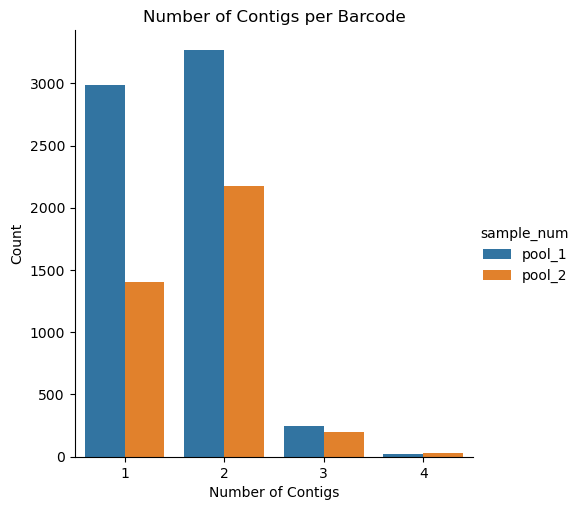

In [4]:
barcode_counts =  config.groupby(['sample_num', 'barcode']).count()[["is_cell"]].reset_index()

num_of_contigs_per_barcode = barcode_counts.groupby(['sample_num', "is_cell"]).count().reset_index()
num_of_contigs_per_barcode = num_of_contigs_per_barcode.rename(columns={"is_cell":"num_contigs", "barcode":"count"})

sns.catplot(data=num_of_contigs_per_barcode,
           x="num_contigs", y="count", hue="sample_num",
           kind="bar").set(title="Number of Contigs per Barcode", 
                           xlabel="Number of Contigs",
                           ylabel="Count");

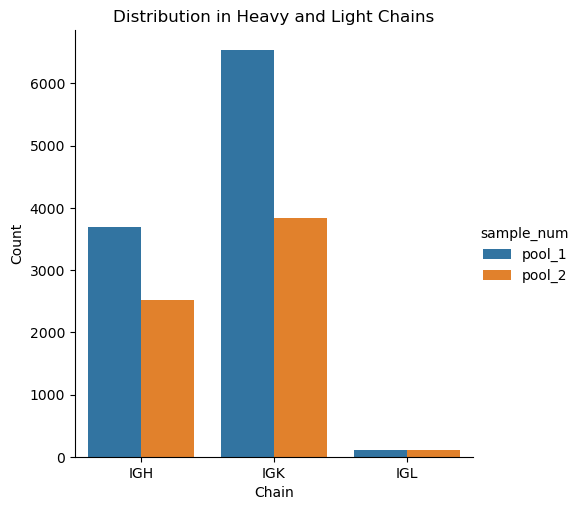

In [10]:
chain_counts = config.groupby(['sample_num', "chain"]).count()[["barcode"]].reset_index().rename(columns={"barcode":"count"})

sns.catplot(data=chain_counts,
           x="chain", y="count", hue="sample_num",
           kind="bar").set(title="Distribution in Heavy and Light Chains",
                          xlabel="Chain", ylabel="Count");

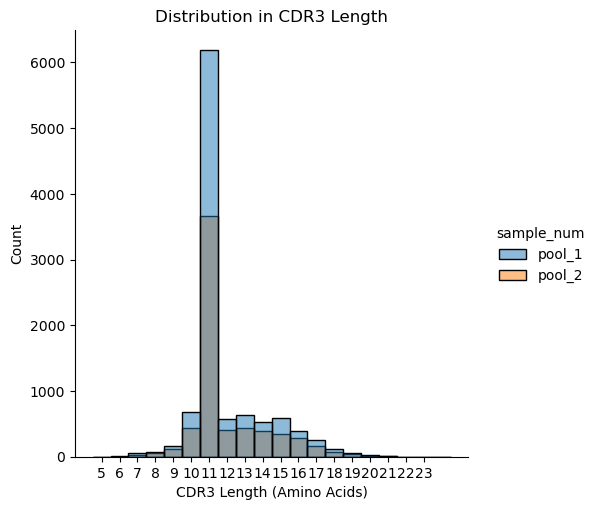

In [11]:
config['cdr3_len'] = pd.Categorical(config['cdr3'].apply(len))

sns.displot(data=config,
           x="cdr3_len", hue="sample_num", bins=19).set(title="Distribution in CDR3 Length",
                            xlabel="CDR3 Length (Amino Acids)",
                            ylabel="Count")

plt.xticks(np.arange(min(config['cdr3_len']), max(config['cdr3_len']), 1));

## Filter Configs

In [5]:
# Select the cells that only have 2 productive sequences
barcode_w_pair_list = barcode_counts[barcode_counts.is_cell == 2]['barcode'].tolist()
filtered_config = config[config.barcode.isin(barcode_w_pair_list)]
filtered_config

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id,sample_num
0,AAACCTGAGCTCTCGG-1,True,AAACCTGAGCTCTCGG-1_contig_1,True,516,IGK,IGKV8-24,NaN,IGKJ2,IGKC,...,CQQHYSTPYTF,TGTCAGCAACATTATAGCACTCCGTACACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,2552,11,clonotype1,clonotype1_consensus_2,1,pool_1
1,AAACCTGAGCTCTCGG-1,True,AAACCTGAGCTCTCGG-1_contig_2,True,568,IGH,IGHV1-53,NaN,IGHJ4,IGHG1,...,CARYYKYDYYAMDFW,TGTGCAAGATACTATAAATACGACTACTATGCTATGGACTTCTGG,GQGTSVTVSS,GGTCAAGGAACCTCAGTCACCGTCTCCTCAG,718,1,clonotype1,clonotype1_consensus_1,1,pool_1
2,AAACCTGAGTGCCATT-1,True,AAACCTGAGTGCCATT-1_contig_1,True,481,IGK,IGKV6-32,NaN,IGKJ2,IGKC,...,CQQDYSSLTF,TGTCAGCAGGATTATAGCTCTCTCACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,154,14,clonotype321,clonotype321_consensus_1,1,pool_1
10,AAACCTGCAGACACTT-1,True,AAACCTGCAGACACTT-1_contig_1,True,499,IGK,IGKV6-23,NaN,IGKJ5,IGKC,...,CQQYSSYPLTF,TGTCAGCAATATAGCAGCTATCCTCTCACGTTC,GAGTKLELK,GGTGCTGGGACCAAGCTGGAGCTGAAAC,124,10,clonotype4173,clonotype4173_consensus_2,1,pool_1
11,AAACCTGCAGACACTT-1,True,AAACCTGCAGACACTT-1_contig_2,True,581,IGH,IGHV8-2,NaN,IGHJ2,IGHM,...,CAWREPYYYGSRDDYW,TGTGCTTGGAGAGAGCCGTATTACTACGGTAGTAGAGATGACTACTGG,GQGTTLTVSS,GGCCAAGGCACCACTCTCACAGTCTCCTCAG,38,4,clonotype4173,clonotype4173_consensus_1,1,pool_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16774,TTTGTCACATGGTAGG-1,True,TTTGTCACATGGTAGG-1_contig_2,True,545,IGH,IGHV1-19,IGHD2-3,IGHJ3,IGHM,...,CARESDGYYSWFAYW,TGTGCAAGAGAGTCTGATGGTTACTACTCCTGGTTTGCTTACTGG,GQGTLVTVSA,GGCCAAGGGACTCTGGTCACTGTCTCTGCAG,136,1,clonotype2164,clonotype2164_consensus_1,1,pool_2
16778,TTTGTCATCACCCGAG-1,True,TTTGTCATCACCCGAG-1_contig_1,True,493,IGK,IGKV15-103,NaN,IGKJ2,IGKC,...,CQQGQSYPYTF,TGTCAACAGGGTCAAAGTTATCCGTACACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,4422,46,clonotype1362,clonotype1362_consensus_2,1,pool_2
16779,TTTGTCATCACCCGAG-1,True,TTTGTCATCACCCGAG-1_contig_2,True,651,IGH,IGHV2-9,NaN,IGHJ2,IGHM,...,CARDLYDYYFDYW,TGTGCCAGAGATCTCTATGATTACTACTTTGACTACTGG,GQGTTLTVSS,GGCCAAGGCACCACTCTCACAGTCTCCTCAG,2758,15,clonotype1362,clonotype1362_consensus_1,1,pool_2
16781,TTTGTCATCGCCAAAT-1,True,TTTGTCATCGCCAAAT-1_contig_1,True,712,IGH,IGHV5-9,NaN,IGHJ2,IGHD,...,CARQGLYGKGRYFDYW,TGTGCAAGACAGGGACTATATGGTAAAGGGAGGTACTTTGACTACTGG,GQGTTLTVSS,GGCCAAGGCACCACTCTCACAGTCTCCTCAG,284,2,clonotype2381,clonotype2381_consensus_1,1,pool_2


## Generate Distance Matricies

In [6]:
# Create a dataframe where one row corresponds to one cell with two sets of chain sequence
heavy_chains = filtered_config[filtered_config['chain'] == "IGH"].set_index('barcode')[['cdr1', 'cdr2', 'cdr3']]
heavy_chains = heavy_chains.rename(columns={"cdr1": "h_cdr1", "cdr2": "h_cdr2", "cdr3": "h_cdr3"})

light_chains = filtered_config[filtered_config['chain'] != "IGH"].set_index('barcode')[['cdr1', 'cdr2', 'cdr3']]
light_chains = light_chains.rename(columns={"cdr1": "l_cdr1", "cdr2": "l_cdr2", "cdr3": "l_cdr3"}) 

chains = heavy_chains.join(light_chains).reset_index()
chains

,barcode,h_cdr1,h_cdr2,h_cdr3,l_cdr1,l_cdr2,l_cdr3
0,AAACCTGAGCTCTCGG-1,GYTFTSY,YPGNGD,CARYYKYDYYAMDFW,KSSQSLLNSSNQKTYLA,FASTRES,CQQHYSTPYTF
1,AAACCTGAGTGCCATT-1,GYTFTSY,YPGSGS,CTSGRAMDYW,KASQSVSNDVA,YASNRYT,CQQDYSSLTF
2,AAACCTGAGTGCCATT-1,GYTFTSY,YPGSGS,CTSGRAMDYW,KASQSVSNDVA,YASNRYT,CQQDYSSLTF
3,AAACCTGCACCACCAG-1,GFSLTSY,WGDGS,CAKQGIYYGYSFAYW,SASSSVSYMH,DTSKLAS,CQQWSSNPYTF
4,AAACCTGCACTATCTT-1,GFSLTSY,WAGGS,CASVVDGAMDYW,RASQSISDYLH,YASQSIS,CQNGHSFPLTF
...,...,...,...,...,...,...,...
8174,TTTGTCATCACCCGAG-1,GFSLTSY,WAGGS,CARDLYDYYFDYW,HASQNINVWLS,KASNLHT,CQQGQSYPYTF
8175,TTTGTCATCACCCGAG-1,GFSLTSY,WAGGS,CARDLYDYYFDYW,HASQNINVWLS,KASNLHT,CQQGQSYPYTF
8176,TTTGTCATCAGAGGTG-1,GFTFSSF,SSGSST,CARSDWGAMDYW,KASQSVDYDGDSYMN,AASNLES,CQQSNEDPFTF
8177,TTTGTCATCCCAAGTA-1,GFTFSSY,SSGGSY,CARGDRSPPGAMDYW,RASQGIRGNLD,STSNLNS,CLQRNAYPYTF


In [7]:
def distance_matrix(cdr):
    # Function that accepts a CDR column and ouputs a levenshtein distance matrix
    # Note: this process is computationally intensive
    
    # Prepare 2 dimensional array M x N (M entries (len cdr3_sequences) with N dimensions (1)) 
    transformed_strings = np.array(cdr).reshape(-1,1)
    
    # Calculate distance matrix using the Levenshtein distance function
    distance_matrix = pdist(transformed_strings, lambda x,y: lev.distance(x[0],y[0]))
    
    # Square distance matrix
    cdr_matrix = squareform(distance_matrix).astype(np.int64)
    
    return cdr_matrix

# Calculate all six distance matricies
h_cdr1_mtx = distance_matrix(chains['h_cdr1'])
h_cdr2_mtx = distance_matrix(chains['h_cdr2'])
h_cdr3_mtx = distance_matrix(chains['h_cdr3'])
l_cdr1_mtx = distance_matrix(chains['l_cdr1'])
l_cdr2_mtx = distance_matrix(chains['l_cdr2'])
l_cdr3_mtx = distance_matrix(chains['l_cdr3'])

In [93]:
def upper_right_no_diag(mtx):
    # Function that gets all the numbers to the upper right of the diagonal, without including the diagonal
    # Return a list of the numbers
    
    cdr_len = mtx.shape[0]
    distance_distribution = []

    for row in np.arange(0, cdr_len-1):
        for col in np.arange(row+1, cdr_len):
            distance_distribution += [mtx[row, col]]
            
    return distance_distribution

In [16]:
# Get the LD distance
#h_cdr1_dist = upper_right_no_diag(h_cdr1_mtx)
#h_cdr2_dist = upper_right_no_diag(h_cdr2_mtx)
#h_cdr3_dist = upper_right_no_diag(h_cdr3_mtx)
#l_cdr1_dist = upper_right_no_diag(l_cdr1_mtx)
#l_cdr2_dist = upper_right_no_diag(l_cdr2_mtx)
#l_cdr3_dist = upper_right_no_diag(l_cdr3_mtx)

In [149]:
def plot_upper_right_no_diag(cdr_dist, chain_str, cdr_str, tick_range):
    
    mean = round(np.mean(cdr_dist), 2)
    sd = round(np.std(cdr_dist), 2)
    
    title=chain_str+ " Chain - "+cdr_str+": mean="+str(mean)+", sd="+str(sd)
    
    sns.countplot(data=cdr_ld_dist, x="h_cdr3_ld").set(title=title, xlabel="Levenshtein Distance (Amino Acids)", ylabel="Count", xticks=tick_range)

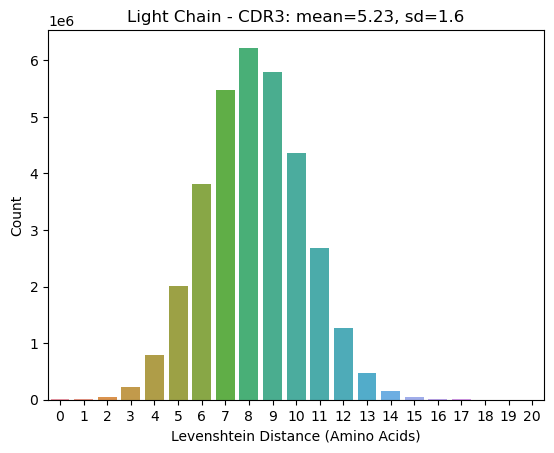

In [155]:
plot_upper_right_no_diag(l_cdr3_dist, "Light", "CDR3", range(0, 21))

## Examine Possible Distance Weights

In [8]:
def meta_distance_matrix(weights=[1, 1, 1, 1, 1, 1]):
    return h_cdr1_mtx*weights[0] + h_cdr2_mtx*weights[1] + h_cdr3_mtx*weights[2] + l_cdr1_mtx*weights[3] + l_cdr2_mtx*weights[4] + l_cdr3_mtx*weights[5]

In [9]:
meta_mtx = meta_distance_matrix()

In [16]:
# Identify the cutoff point on whether there should be an edge between two nodes 
# Based on https://www.frontiersin.org/articles/10.3389/fimmu.2018.00224/full#h3, 
# the standard is one amino acid difference
cutoff_point = 6

# Generate binary boolean distance matrix
boolean_filter = meta_mtx <= cutoff_point
boolean_filter = boolean_filter.astype(int)

G = nx.Graph()

# Add the nodes per unique sequence
G.add_nodes_from(np.arange(meta_mtx.shape[0]))

# Add the edges
# Take the upper right triangular matrix w/out diagnonal
# https://people.revoledu.com/kardi/tutorial/VB/tips/Symmetric-Matrix.html
for row in np.arange(0, meta_mtx.shape[0]-1):
    for col in np.arange(row+1, meta_mtx.shape[0]):
        if boolean_filter[row, col] == 1:
            G.add_weighted_edges_from([(row, col, 1)])

# Set node weights based on number of edges
#node_degree = [G.degree(x) for x in np.arange(len(cdr3_sequences))]
#for i in np.arange(len(cdr3_sequences)):
#    G.nodes[i]['size'] = node_degree[i]

# Node degree - number of edges per node
# Calculate this before removing the nodes with no edges
#degree_sequence = [d for n, d in G.degree()]

# Remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))

# To visualize graph (note: computationally intensive)
#gv.d3(G, edge_size_data_source='weight', use_node_size_normalization=True)

clusters = sorted(nx.connected_components(G), key=len, reverse=True)
top10_clusters = [list(x) for x in clusters[:10]]

In [17]:
[len(x) for x in top10_clusters]

[120, 97, 89, 80, 48, 47, 42, 35, 34, 32]

## Consensus Analysis

In [84]:
top_cluster_sequences = chains.iloc[top10_clusters[0], :]

top_cluster_sequences.head()

,barcode,h_cdr1,h_cdr2,h_cdr3,l_cdr1,l_cdr2,l_cdr3
7718,TGTGTTTTCGTCCGTT-1,GFTFSGF,NSDGSA,CMRYDGYYWYFDVW,KASQDIKSYLS,YATSLAD,CLQHGESPLTF
1086,AGCGGTCCATTGTGCA-1,GFTFSGF,NSDGSA,CMRYGSSYWYFDVW,KASQDIKSYLS,YATSLAD,CLQHGESPFTF
1087,AGCGGTCCATTGTGCA-1,GFTFSGF,NSDGSA,CMRYGSSYWYFDVW,KASQDIKSYLS,YATSLAD,CLQHGESPFTF
1088,AGCGGTCCATTGTGCA-1,GFTFSGF,NSDGSA,CMRYGSSYWYFDVW,KASQDIKSYLS,YATSLAD,CLQHGESPFTF
1089,AGCGGTCCATTGTGCA-1,GFTFSGF,NSDGSA,CMRYGSSYWYFDVW,KASQDIKSYLS,YATSLAD,CLQHGESPFTF


In [18]:
def cluster_consensus_sequence(cluster_df, most_common_aa_cutoff = 75, num_possible_aa = 2):
    # Input:
    ## Cluster sequence dataframe
    ## Most common aa cutoff - If an amino acid at a position is x% or higher, it will always be that amino acid at that position
    ## Number of possible amino acids - selects the n number of possible amino acids per position, in highest to lowest frequency
    
    # Output:
    ## Consensus sequences per CDR region
    ## Percent frequency of each amino acid per position, useful for visualization purposes
    
    cluster_consensus_sequence_results = {}
    
    percentage_position_matrix_list = {}
    
    aa_options = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'B', 'Z', 'X']
    
    cdr_column_names = cluster_df.columns[cluster_df.columns.str.contains("cdr")].to_list()
    
    for cdr_column_name in cdr_column_names:
        
        # If there is only one unique cdr sequence, then just add it to the results output
        if len(cluster_df[cdr_column_name].unique()) == 1:
            cluster_consensus_sequence_results[cdr_column_name] = [cluster_df[cdr_column_name].unique()[0]]
            
        # If there is more than one, conduct multiple sequencing alignment (MSA)
        else:
            # Convert text to ProteinSequence data type from biotite
            seq_to_align = [seq.ProteinSequence(cdr_sequence) for cdr_sequence in cluster_df[cdr_column_name]]
            
            # Conduct MSA
            biotite_sub_matrix = seq.align.SubstitutionMatrix.std_protein_matrix()
            alignment, order, tree, distances = seq.align.align_multiple(seq_to_align, biotite_sub_matrix)
            
            # Extract the aligned sequences, convert None to "-"
            alignment_mtx = np.array(seq.align.get_symbols(alignment))
            alignment_mtx[alignment_mtx == None] = "-"
            
            # Create a percentage position matrix where for each amino acid position, there is a percentage frequency for all amino acids
            raw_data = {}

            for aa in aa_options:
                raw_data[aa] = list(np.sum(alignment_mtx == aa, axis=0)/alignment_mtx.shape[0]*100)
                
            # Save results for visualizing percentage position if desired
            percentage_position_matrix_list[cdr_column_name] = raw_data
                
            # Generate the consensus sequences based on percent_cutoff and num_possible_aa
            percent_position_matrix = pd.DataFrame(raw_data, columns=raw_data.keys())
            
            # Create a list where every sublist is one position and has num_possible_aa number of amino acids at that position for consensus generation
            common_aa_per_position = []
            
            for position_idx in np.arange(percent_position_matrix.shape[0]):
                
                position = percent_position_matrix.iloc[position_idx]
                
                # If a amino acid occurs most_common_aa_cutoff% at a position, it is always that amino acid
                if len(position[position >= most_common_aa_cutoff]) == 1:
                    common_aa = position[position >= most_common_aa_cutoff].index.to_list()
                    
                # If the position is more diverse, select the top num_possible_aa
                else:
                    common_aa = position.sort_values(ascending=False)[:num_possible_aa].index.to_list()
    
                common_aa_per_position += [common_aa]
    
            # Generate all the possible consensus sequence combinations 
            cdr_consensus_sequences = [list(x) for x in itertools.product(*common_aa_per_position)]
        
            cluster_consensus_sequence_results[cdr_column_name] = cdr_consensus_sequences
        
    return cluster_consensus_sequence_results, percentage_position_matrix_list

In [146]:
top_cluster_consensus, top_cluster_pp = cluster_consensus_sequence(top_cluster_sequences)

In [15]:
top10_clusters

,h_cdr1,h_cdr2,h_cdr3,l_cdr1,l_cdr2,l_cdr3


In [19]:
top10_clusters_counts = pd.DataFrame(columns=chains.columns[chains.columns.str.contains("cdr")])

for clusters_idxs in top10_clusters:
    cluster_seq = chains.iloc[clusters_idxs, :]
    
    cluster_consensus, cluster_pp = cluster_consensus_sequence(cluster_seq, most_common_aa_cutoff = 75, num_possible_aa = 3)
    
    num_consensus = [len(x) for x in top_cluster_consensus]
    
    top10_clusters_counts.loc[len(top10_clusters_counts.index)] = num_consensus
    
top10_clusters_counts['num_barcodes'] = [len(x) for x in top10_clusters]

NameError: name 'itertools' is not defined

In [124]:
top_cluster_sequences['l_cdr3'].unique()

array(['CLQHGESPLTF', 'CLQHGESPFTF', 'CLQHGESPYTF', 'CLQHGESPWTF'],
      dtype=object)

In [125]:
# Align the CDR3 sequences within the largest network using the MUSCLE alignment tool
seq_to_align = []
for cdr3 in top_cluster_sequences['l_cdr3']:
    seq_to_align += [seq.ProteinSequence(cdr3)]
    
matrix = seq.align.SubstitutionMatrix.std_protein_matrix()
alignment, order, tree, distances = seq.align.align_multiple(seq_to_align, matrix)

In [126]:
alignment_mtx = np.array(seq.align.get_symbols(alignment))
alignment_mtx[alignment_mtx == None] = "-"

In [127]:
# Create a percentage position matrix where for each position, there is a percentage for all the amino acids
aa_options = np.unique(alignment_mtx)

raw_data = {}

for aa in aa_options:
    raw_data[aa] = list(np.sum(alignment_mtx == aa, axis=0)/alignment_mtx.shape[0]*100)

percent_position_matrix = pd.DataFrame(raw_data, columns=raw_data.keys())
percent_position_matrix

,C,E,F,G,H,L,P,Q,S,T,W,Y
0,100.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.0,100.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
6,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.000000,0.0
7,0.0,0.0,0.000000,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.000000,0.0
8,0.0,0.0,23.333333,0.0,0.0,45.0,0.0,0.0,0.0,0.0,4.166667,27.5
9,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.000000,0.0


In [ ]:
percent_cutoff = 20
num_possible_aa = 2

common_aa_per_position = []
for position_idx in np.arange(percent_position_matrix.shape[0]):
    
    # For each position, filter out the amino acids that are lower than the percent cutoff point
    position = percent_position_matrix.iloc[position_idx] #[percent_position_matrix.iloc[position_idx] >= percent_cutoff]
    
    if len(position[position > 75]) == 1:
        common_aa = position[position > 75].index.to_list()
        
    else:
        common_aa = position.sort_values(ascending=False)[:num_possible_aa].index.to_list()
                    
    # Sort the amino acids and select the top number of desired amino acids if possible
    #position = position.sort_values(ascending=False).index.to_list()[:num_possible_aa]
        
    common_aa_per_position += [common_aa]
    
possible_consensus_sequence = [list(x) for x in itertools.product(*common_aa_per_position)]

In [139]:
percent_position_matrix.iloc[8].sort_values(ascending=False)[:3].index.to_list()

['L', 'Y', 'F']

In [141]:
possible_consensus_sequence

[['C', 'L', 'Q', 'H', 'G', 'E', 'S', 'P', 'L', 'T', 'F'],
 ['C', 'L', 'Q', 'H', 'G', 'E', 'S', 'P', 'Y', 'T', 'F']]